<a target="_blank" href="https://colab.research.google.com/github/chung-neuroai-lab/SNAP/blob/main/SNAP_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Run this cell to install the code and dependencies. This might not be necessary if you cloned the repo locally, but it is helpful for colab. 


In [ ]:
# Clone the project GitHub and install with the setup.py file. 
!git clone git@github.com:chung-neuroai-lab/SNAP.git
cd SNAP
pip install . 
# Brainscore is installed separately from setup.py because of some conflicting dependencies
# at time of code release
!pip install git+git@github.com:chung-neuroai-lab/SNAP.git@updates_for_public_release
!pip install git+https://github.com/brain-score/brainio.git
!pip install git+https://github.com/brain-score/result_caching
!pip install --no-deps git+https://github.com/brain-score/brain-score

## Imports and setting some paths for the data. 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

from dimensionality.wrapper import TorchWrapper
from dimensionality.experiment import Experiment
from dimensionality.brainscore_data import get_neural_data
from dimensionality.regression_utils import regression_metric
import dimensionality.models as models
from dimensionality.data_utils import DataProcess
from dimensionality import figure_utils

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

data_root = 'data/'
os.makedirs(data_root, exist_ok=True)
device = 'cuda'

## Run the analysis computing the theoretical and empirical generalization error, and measures for error mode geometry


In [14]:
# Model list to analyze -- code can be RAM intensive so choosing
# a small model here for demo.
modelNames = ['resnet18',
              ]

# These are the 4 regions analyzed from the Brain-Score datasets.
# Only analyzing V1 and V2 in demo for speed and compute.
regionNames = ['V1',
               'V2',
              #  'V4',
              #  'IT'
               ]

# Options are available for pooling the activations after extracting them.
# In the 2023 NeurIPS paper main text experiments we use the full activations.
activation_pooling = [None,
                      #   'MaxPool_(1,1)',
                      #   'AvgPool_(1,1)',
                      ]

# Option for subsampling activations by randomly projecting the data
# In the 2023 NeurIPS paper we use the full activations.
rand_proj_dim = None

pretrained = {True: 'pretrained',
              False: 'untrained'
              }

# Pytorch arguments for loading the dataset.
loader_kwargs = {'batch_size': 200,
                 'shuffle': False,
                 'num_workers': 2,
                 'pin_memory': True,
                 'onehot': True,
                 'labels_from': 'neural_activity'
                }

In [15]:
# Loop through the analyses specified above.
for region in regionNames:
    data_loader_neural, images, labels = get_neural_data(region=region,
                                            loader_kwargs=loader_kwargs)
    for model_name in modelNames:
        for pooling in activation_pooling:
            for trained in [True, False]:
                data_dir = os.path.join(data_root,
                    f"data_{pooling}_RandProj_{rand_proj_dim}")
                data_fname = os.path.join(data_dir,
                    f"{region}_data_{model_name}_{pretrained[trained]}.npz")
                os.makedirs(data_dir, exist_ok=True)
                print(data_fname)

                # Get the model
                model_kwargs = {'name': model_name,
                                'pretrained': trained,
                                'device': device}
                model, layers, identifier = models.get_model(**model_kwargs)
                model_wrapped = TorchWrapper(model,
                                             layers=layers,
                                             identifier=identifier,
                                             activation_pooling=pooling)

                # Create the Experiment Class and pass additional metrics
                regression_kwargs = {'num_trials': 5,
                                     'reg': 1e-14,
                                     'num_points': 5,
                                     }

                metric_fns = [regression_metric]
                exp = Experiment(model_wrapped,
                                 metric_fns=metric_fns,
                                 rand_proj_dim=rand_proj_dim)

                # Extract the activations of the layers passed above
                # using data_loader (only uses the inputs)
                exp.get_activations(data_loader_neural())

                # Compute metrics
                metric_kwargs = {'debug': False,
                                 'epsilon': 1e-14
                                 } | regression_kwargs

                exp_metrics = exp.compute_metrics(images=images,
                                                  labels=labels,
                                                  **metric_kwargs)
                layers = exp_metrics['layers']

                # Save all of the metrics so we can load them.
                np.savez(data_fname, exp_metrics=exp_metrics,
                         layers=layers, metric_kwargs=metric_kwargs)

/usr/local/lib/python3.10/dist-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):
Batch: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


torch.Size([135, 3, 224, 224]) torch.Size([135, 102])
data/data_None_RandProj_None/V1_data_resnet18_pretrained.npz
Getting layer activations...


Batch: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


Computing metrics...
Computing metrics for ['layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu', 'image_layer', 'response_layer']
{'layer1.0.relu': torch.Size([135, 200704]), 'layer1.1.relu': torch.Size([135, 200704]), 'layer2.0.relu': torch.Size([135, 100352]), 'layer2.1.relu': torch.Size([135, 100352]), 'layer3.0.relu': torch.Size([135, 50176]), 'layer3.1.relu': torch.Size([135, 50176]), 'layer4.0.relu': torch.Size([135, 25088]), 'layer4.1.relu': torch.Size([135, 25088]), 'image_layer': torch.Size([135, 150528]), 'response_layer': torch.Size([135, 102])}
Computing spectrum...


Layer: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Computing regression_metric...


Layer: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


Metric Computation completed!
data/data_None_RandProj_None/V1_data_resnet18_untrained.npz
Getting layer activations...


Batch: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Computing metrics...
Computing metrics for ['layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu', 'image_layer', 'response_layer']
{'layer1.0.relu': torch.Size([135, 200704]), 'layer1.1.relu': torch.Size([135, 200704]), 'layer2.0.relu': torch.Size([135, 100352]), 'layer2.1.relu': torch.Size([135, 100352]), 'layer3.0.relu': torch.Size([135, 50176]), 'layer3.1.relu': torch.Size([135, 50176]), 'layer4.0.relu': torch.Size([135, 25088]), 'layer4.1.relu': torch.Size([135, 25088]), 'image_layer': torch.Size([135, 150528]), 'response_layer': torch.Size([135, 102])}
Computing spectrum...


Layer: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Computing regression_metric...


Layer: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


Metric Computation completed!


Batch: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


torch.Size([135, 3, 224, 224]) torch.Size([135, 103])
data/data_None_RandProj_None/V2_data_resnet18_pretrained.npz
Getting layer activations...


Batch: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Computing metrics...
Computing metrics for ['layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu', 'image_layer', 'response_layer']
{'layer1.0.relu': torch.Size([135, 200704]), 'layer1.1.relu': torch.Size([135, 200704]), 'layer2.0.relu': torch.Size([135, 100352]), 'layer2.1.relu': torch.Size([135, 100352]), 'layer3.0.relu': torch.Size([135, 50176]), 'layer3.1.relu': torch.Size([135, 50176]), 'layer4.0.relu': torch.Size([135, 25088]), 'layer4.1.relu': torch.Size([135, 25088]), 'image_layer': torch.Size([135, 150528]), 'response_layer': torch.Size([135, 103])}
Computing spectrum...


Layer: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Computing regression_metric...


Layer: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Metric Computation completed!
data/data_None_RandProj_None/V2_data_resnet18_untrained.npz
Getting layer activations...


Batch: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Computing metrics...
Computing metrics for ['layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu', 'image_layer', 'response_layer']
{'layer1.0.relu': torch.Size([135, 200704]), 'layer1.1.relu': torch.Size([135, 200704]), 'layer2.0.relu': torch.Size([135, 100352]), 'layer2.1.relu': torch.Size([135, 100352]), 'layer3.0.relu': torch.Size([135, 50176]), 'layer3.1.relu': torch.Size([135, 50176]), 'layer4.0.relu': torch.Size([135, 25088]), 'layer4.1.relu': torch.Size([135, 25088]), 'image_layer': torch.Size([135, 150528]), 'response_layer': torch.Size([135, 103])}
Computing spectrum...


Layer: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Computing regression_metric...


Layer: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

Metric Computation completed!


## Process the data for the individual files

Combine the data for the individual experiments analyzed above.

In [16]:
processed_data_root = os.path.join(data_root, 'processed/')

os.makedirs(processed_data_root, exist_ok=True)

rand_projections = ['None']
activation_pooling = ['None']
pooling_list = []
for item in product(activation_pooling, rand_projections):
    pooling_list += ["_RandProj_".join(item)]
activation_pooling = pooling_list.copy()

Data = DataProcess(data_root,
                   activation_pooling,
                   regionNames,
                   modelNames,
                   pretrained)
dfs_all = Data.get_dataframe(load=False, save_all_data_pckl=True)

sort_coord = 'final_scores'
threshold = 0.99

region_list = Data.region_list
pooling_list = Data.pooling_list
model_list = Data.model_list

for trained in pretrained.keys():
  for region in region_list:
      for pooling in pooling_list:
          print(region, pooling)
          processed_data_name = os.path.join(processed_data_root,
                                             f'{region}_{pooling}_{pretrained[trained]}.npz')

          all_data_kwargs = dict(sort_coord=sort_coord,
                                 trained=trained,
                                 region_list=[region],
                                 pooling_list=[pooling],
                                 model_list=model_list,
                                 eff_dim_cutoff=0,
                                 threshold=threshold,
                                 )
          all_reg_hist, all_processed_data = Data.get_all_data(**all_data_kwargs)
          all_reg_hist = all_reg_hist[region][pooling]
          all_processed_data = all_processed_data[region][pooling]

          np.savez(processed_data_name,
                   all_reg_hist=all_reg_hist,
                   all_processed_data=all_processed_data,
                   all_data_kwargs=all_data_kwargs)

Generating dataframe
Done!
V1 None_RandProj_None
V2 None_RandProj_None
V1 None_RandProj_None
V2 None_RandProj_None


## Example Figures

Load in the data for the figure plotting and make the theory vs. empirical plot and some example contour plots. 

In [18]:
# Only looking at full activations, no random projections
activation_pooling = ['None']
rand_projections = ["None"]
pooling = 'None_RandProj_None'
p_idx = -5 # Corresponds to 60/40 train/test split

(all_reg_hist,
 all_processed_data,
 all_data_kwargs) = figure_utils.get_processed_data_figs(region_list,
                                                         pooling_list,
                                                         trained=True,
                                                         )
(all_reg_hist_random,
 all_processed_data_random,
 all_data_kwargs_random) = figure_utils.get_processed_data_figs(region_list,
                                                                pooling_list,
                                                                trained=False,
                                                                )

## Theory = Empirical Scatter Plot


V1: P = 0.609p, 8 Model-Stages Analyzed
V2: P = 0.609p, 8 Model-Stages Analyzed


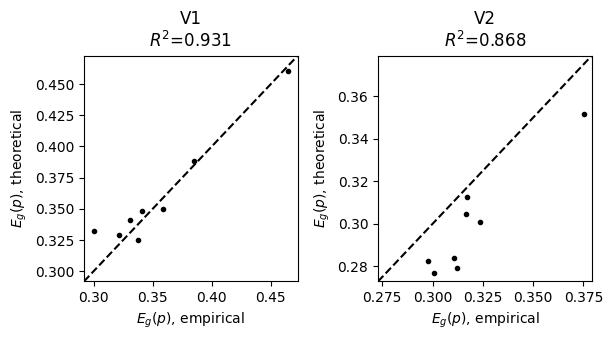

In [20]:
plt.figure(figsize=(12, 3.5))

for r_idx, region in enumerate(region_list):
    plt.subplot(1, 4, r_idx+1)

    x_val = []
    y_val = []
    p_val = []
    p_max = []
    for model, model_data in all_processed_data[region][pooling].items():
        p_val.append(model_data['pvals_mode'][:, p_idx])
        p_max.append(model_data['pvals_mode'][:, -1])

        x_val.append(model_data['gen_errs'][:, p_idx])

        r = model_data['dyn_weight_rads'][:, p_idx]
        sqrt_d = model_data['dyn_tads'][:, p_idx]

        y_val.append(r * sqrt_d)

    x_val = np.concatenate(x_val)
    y_val = np.concatenate(y_val)
    p_val = np.concatenate(p_val)
    p_max = np.concatenate(p_max)

    assert (len(np.unique(p_val)) == 1)
    assert (len(np.unique(p_max)) == 1)

    r = np.corrcoef(x_val, y_val)[0, 1]

    plt.scatter(x_val,
                y_val,
                marker='.',
                color='k'
                )

    p_frac = np.unique(p_val)[0]/np.unique(p_max)[0]
    plt.title('%s\n$R^2$=%0.3f' % (region, r**2))
    plt.xlabel('$E_g(p)$, empirical')
    plt.ylabel('$E_g(p)$, theoretical')

    x_l = plt.xlim()
    y_l = plt.ylim()

    lims = [min(x_l[0], y_l[0]), max(x_l[1], y_l[1])]
    plt.xlim([lims[0], lims[1]])
    plt.ylim([lims[0], lims[1]])
    plt.plot([lims[0], lims[1]],
             [lims[0], lims[1]],
             'k--')

    print('%s: P = %0.3fp, %s Model-Stages Analyzed' % (region, p_frac, len(x_val)))

plt.tight_layout()

## Contour plots coded by the generalization error

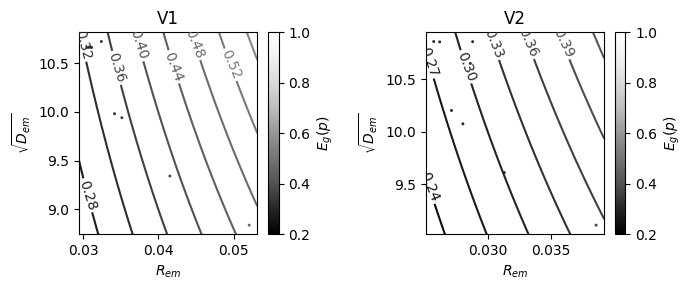

In [21]:
# Good for training data, showing the generalization error
cmap_min = 0.2
cmap_max = 1.

figs, ax = plt.subplots(nrows=1,
                        ncols=len(region_list),
                        figsize=(len(region_list)*3.5, 3),
                        )
ax = ax.ravel()

_ = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                      pooling,
                                      p_idx=p_idx,
                                      x_lims=None,
                                      y_lims=None,
                                      coloring='gen_errs',
                                      c_map_min=cmap_min,
                                      c_map_max=cmap_max,
                                      marker_size=5,
                                      ax_handle=ax,
                                      cmap='Greys_r',
                                      save_figures=False,
                                      )

## Contour plots coded by the normalized layer-depth

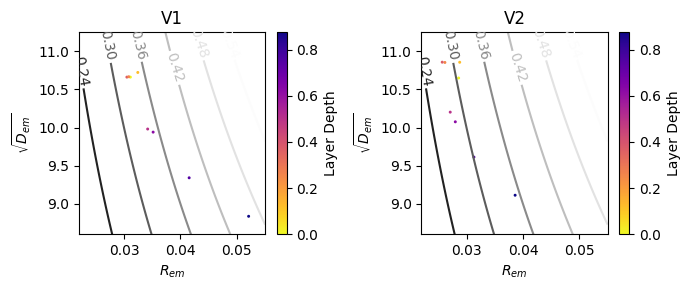

In [26]:
figs, ax = plt.subplots(nrows=1,
                        ncols=len(region_list),
                        figsize=(len(region_list)*3.5, 3),
                        )
ax = ax.ravel()

x_lims_cropped = {'V1': [0.022, 0.055],
          'V2': [0.022, 0.055],
          'V4': [0.004, 0.012],
          'IT': [0.004, 0.012]}

y_lims_cropped = {'V1': [8.6, 11.25],
          'V2': [8.6, 11.25],
          'V4': [38, 50],
          'IT': [39, 51.5]}

cropped_contour_min_max = [0.2, 0.55]
layer_data = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                               pooling,
                                               p_idx=p_idx,
                                               x_lims=x_lims_cropped,
                                               y_lims=y_lims_cropped,
                                               coloring='layer_depth_normalized',
                                               c_map_min_contours=cropped_contour_min_max[0],
                                               c_map_max_contours=cropped_contour_min_max[1],
                                               cmap=plt.cm.plasma_r,
                                               c_bar_label='Layer Depth',
                                               marker_size=5,
                                               ax_handle=ax,
                                               cmap_contours='Greys_r',
                                               save_figures=False,
                                               )
